<a href="https://colab.research.google.com/github/keyvany/decision-making-/blob/main/two_loops_catproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ANNArchy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.7/505.7 kB 8.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ANNArchy: filename=ANNarchy-4.8.2.3-cp311-cp311-linux_x86_64.whl size=2148499 sha256=998bc7476a4094839654b0e3d6125f24dd5ed50da74f7eebda702e8d3878fe6d
  Stored in directory: /root/.cache/pip/wheels/f4/c0/4c/b40ff9af74a8eefc7f4fb855fdc6d02de0573c56e2b59416bd
Successfully built ANNArchy


In [ ]:
pip install CompNeuroPy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.0/249.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 665.2/665.2 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.2/334.2 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 41.4 MB/s eta 0:00:00


In [ ]:



import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from ANNarchy import (
    Neuron,
    Population,
    Projection,
    Synapse,
    setup,
    compile,
    Uniform,
    simulate,

)
import numpy as np
import random
from CompNeuroPy import CompNeuroMonitors, get_full_model, PlotRecordings


# Setup ANNarchy
setup(dt=1.0, num_threads=1)

# General parameters
ITdimension = 10
baseline_it = random.uniform(0.0, 0.1)
response_threshold = 0.5
nr_fish_presentations = 100

fish_list = [
    [
        [-1.0, 0.0, -1.0, 0.0],
        [-0.5, 0.0, 1.0, 1.0],
        [-0.5, 0.5, 0.5, 1.0],
        [-1.0, 0.5, 0.0, 1.0],
        [0.0, 1.0, 1.0, -1.0],
        [0.0, 1.0, 1.0, 0.0],
    ],
    [
        [1.0, 0.0, -1.0, 0.0],
        [0.0, -1.0, -1.0, 0.0],
        [0.5, 0.0, 0.0, 1.0],
        [0.0, -1.0, 1.0, 0.0],
        [1.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 0.0],
    ],
]
feature_name_list = ["DF", "TF", "VF", "MA"]


# define the durations of the events
trial_duration = 200
dopamine_input_duration = 300
deactivate_input_duration = 30
calcium_trace_decline_duration = 100

# Set the dopamine condition
max_dopa = 1.5
baseline_dopa = 0.1
baseline_snc = 0.1
min_dopa = 0.0
K_dip = 0.4


# Neuron models
# In Fran's version SaturatedNeuron=LinearNeuron and NormalizationNeuron=LinearNeuron and LinearNeuronPFC=LinearNeuron
LinearNeuron = Neuron(
    parameters="""
        tau = 20.0
        baseline = 0.0
        noise = 0.0
    """,
    equations="""
        tau*dmp/dt + mp = sum(exc) - sum(inh) + baseline + noise*Uniform(-1.0,1.0)
        r = pos(mp)
    """,
)

DopamineNeuron = Neuron(
    parameters="""
        tau = 20.0
        firing = 0
        inhibition = 0.0
        baseline = 0.0
    """,
    equations="""
        ex_in = if (sum(exc)>0): 1 else: 0
        s_inh = sum(inh)
        aux = if (firing>0): (ex_in)*(pos(1.0-baseline-s_inh) + baseline) + (1-ex_in)*(-10*sum(inh)+baseline)  else: baseline
        tau*dmp/dt + mp =  aux
        r = if (mp>0.0): mp else: 0.0
    """,
)

InputNeuron = Neuron(
    parameters="""
        tau = 1.5
        baseline = 0.0
    """,
    equations="""
        tau*dmp/dt + mp = baseline
        baseline_rec = baseline
        r = if (mp>0.0): mp else: 0.0
    """,
)

# Synapse models
# ?? population?
PostCovariance = Synapse(
    parameters="""
        tau = 1000.0
        tau_alpha = 10.0
        regularization_threshold = 1.0
        threshold_post = 0.0
        threshold_pre = 0.0
    """,
    equations="""
        tau_alpha*dalpha/dt  + alpha =  pos(post.mp - regularization_threshold)


        trace = (pre.r - mean(pre.r) - threshold_pre) * pos(post.r - mean(post.r) - threshold_post)
    delta = (trace - alpha*pos(post.r - mean(post.r) - threshold_post)*pos(post.r - mean(post.r) - threshold_post)*w)
        tau*dw/dt = delta : min=0
   """,
)

ReversedSynapse = Synapse(
    parameters="""
        reversal = 1.0
    """,
    psp="""
        w*pos(reversal-pre.r)
    """,
)

# DA_typ = 1  ==> D1 type  DA_typ = -1 ==> D2 type
DAPostCovarianceNoThreshold = Synapse(
    parameters="""
        tau=1000.0
        tau_alpha=10.0
        regularization_threshold=1.0
        baseline_dopa = 0.1
        K_burst = 1.0
        K_dip = 0.4
        DA_type = 1
        threshold_pre=0.0
        threshold_post=0.0
    """,
    equations="""
        tau_alpha*dalpha/dt  + alpha = pos(post.mp - regularization_threshold)
        dopa_sum = 2.0*(post.sum(dopa) - baseline_dopa)

        trace = pos(post.r -  mean(post.r) - threshold_post) * (pre.r - mean(pre.r) - threshold_pre)

    condition_0 = if (trace>0.0) and (w >0.0): 1 else: 0

        dopa_mod = if (DA_type*dopa_sum>0): DA_type*K_burst*dopa_sum else: condition_0*DA_type*K_dip*dopa_sum


        delta = (dopa_mod* trace - alpha*pos(post.r - mean(post.r) - threshold_post)*pos(post.r - mean(post.r) - threshold_post))
        tau*dw/dt = delta : min=0
    """,
)

# Excitatory synapses STN -> GPi
DAPreCovariance_excitatory = Synapse(
    parameters="""
    tau=1000.0
    tau_alpha=10.0
    regularization_threshold=1.0
    baseline_dopa = 0.1
    K_burst = 1.0
    K_dip = 0.4
    DA_type= 1
    threshold_pre=0.0
    threshold_post=0.0
    """,
    equations="""
        tau_alpha*dalpha/dt  = pos( post.mp - regularization_threshold) - alpha
        dopa_sum = 2.0*(post.sum(dopa) - baseline_dopa)

        trace = pos(pre.r - mean(pre.r) - threshold_pre) * (post.r - mean(post.r) - threshold_post)
        aux = if (trace<0.0): 1 else: 0
        dopa_mod = if (dopa_sum>0): K_burst * dopa_sum else: K_dip * dopa_sum * aux
        delta = dopa_mod * trace - alpha * pos(trace)
        tau*dw/dt = delta : min=0


    """,
)

# Inhibitory synapses GPi -> GPi and STRD2 -> GPe
DAPreCovariance_inhibitory = Synapse(
    parameters="""
    tau=1000.0
    tau_alpha=10.0
    regularization_threshold=1.0
    baseline_dopa = 0.1
    K_burst = 1.0
    K_dip = 0.4
    DA_type= 1
    threshold_pre=0.0
    threshold_post=0.0
    """,
    equations="""
        tau_alpha*dalpha/dt = pos( -post.mp - regularization_threshold) - alpha
        dopa_sum = 2.0*(post.sum(dopa) - baseline_dopa)

        trace = pos(pre.r - mean(pre.r) - threshold_pre) * (mean(post.r) - post.r  - threshold_post)
        aux = if (trace>0): 1 else: 0

        dopa_mod = if (DA_type*dopa_sum>0): DA_type*K_burst*dopa_sum else: aux*DA_type*K_dip*dopa_sum

        delta = dopa_mod * trace - alpha * pos(trace)
        tau*dw/dt = delta : min=0
    """,
)

DAPrediction = Synapse(
    parameters="""
        tau = 100000.0
        baseline_dopa = 0.1
   """,
    equations="""
       aux = if (post.sum(exc)>0): 1.0 else: 3.0
       delta = aux*(post.r - baseline_dopa)*pos(pre.r - mean(pre.r))
       tau*dw/dt = delta : min=0
   """,
)


# Populations
# IT Input
IT = Population(name="IT", geometry=(
    ITdimension, ITdimension), neuron=InputNeuron)
IT.tau = 20.0
IT.baseline = baseline_it

# FEF Input
FEF = Population(name="FEF", geometry=(
    ITdimension, ITdimension), neuron=InputNeuron)
FEF.tau = 10.0
FEF.baseline = baseline_it

# Lateral SNr
SNr = Population(name="SNr", geometry=2, neuron=LinearNeuron)
SNr.tau = 10.0
SNr.noise = 0.0
SNr.baseline = 0

# Reward Input
Reward_Layer = Population(name="Reward_Layer", geometry=1, neuron=InputNeuron)
Reward_Layer.tau = 1.0

# PFC_MTL
MTL = Population(name="PFC_MTL", geometry=(4, 9), neuron=LinearNeuron)
MTL.tau = 100.0
MTL.noise = 0.0
MTL.baseline = 0.0

# SNc
SNc = Population(name="SNc", geometry=1, neuron=DopamineNeuron)
SNc.tau = 10.0
SNc.firing = 0.0
SNc.baseline = baseline_snc

# Striatum direct pathway
StrD1 = Population(name="StrD1", geometry=(4, 4), neuron=LinearNeuron)
StrD1.tau = 10.0
StrD1.noise = 0.0
StrD1.baseline = 0.4

# Striatum indirect pathway
StrD2 = Population(name="StrD2", geometry=(4, 4), neuron=LinearNeuron)
StrD2.tau = 10.0
StrD2.noise = 0.0
StrD2.baseline = 0.4

# Striatum feedback pathway
StrThal = Population(name="StrThal-PFC", geometry=2, neuron=LinearNeuron)
StrThal.tau = 10.0
StrThal.noise = 0.0
StrThal.baseline = 0.4

# GPi
GPi = Population(name="GPi", geometry =2, neuron=LinearNeuron)
GPi.tau = 10.0
GPi.noise = 0.0
GPi.baseline = 0.0


# STN
STN = Population(name="STN", geometry = (4,4), neuron=LinearNeuron)
STN.tau = 10.0
STN.noise = 0.0
STN.baseline = 0.0

# GPe
GPe = Population(name="GPe", geometry = 2, neuron=LinearNeuron)
GPe.tau = 10.0
GPe.noise = 0.0
GPe.baseline = 0.0

# VA
VA = Population(name="VA-PFC", geometry=2, neuron=LinearNeuron)
VA.tau = 10.0
VA.noise = 0.0001
VA.baseline = 0.0

# PM
PM = Population(name="PM", geometry = 2, neuron=LinearNeuron)
PM.tau = 10.0
PM.noise = 0.0
PM.noise=0.0
#Projections#Projections
# SC
SC = Population(name="SC", geometry=4, neuron=LinearNeuron)
SC.tau = 1000.0
SC.noise = 1.0
SC.baseline=0.2

# caudate direct pathway
Cau1 = Population(name="Cau1", geometry=(4,4), neuron=LinearNeuron)
Cau1.tau = 10.0
Cau1.noise = 0.1
Cau1.baseline = 0.4

Cau2 = Population(name="Cau2", geometry=(4,4), neuron=LinearNeuron)
Cau2.tau = 10.0
Cau2.noise = 0.1
Cau2.baseline = 0.4

# Projections
ITMTL = Projection(pre=IT, post=MTL, target="exc", synapse=PostCovariance)
ITMTL.connect_all_to_all(weights=Uniform(0.2, 0.4))  # Normal(0.3,0.1) )
ITMTL.tau = 10
ITMTL.regularization_threshold = 3.5
ITMTL.tau_alpha = 1.0
ITMTL.baseline_dopa = baseline_dopa
ITMTL.threshold_post = 0.0
ITMTL.thrshold_pre = 0.15
#ITMTL.w = np.random.uniform(0.1, 0.5, ITMTL.w.shape)



MTLVA_11 = Projection(pre=MTL[0:8], post=VA[0], target="exc")
MTLVA_11.connect_all_to_all(weights=0.15)
MTLVA_22 = Projection(pre=MTL[8:16], post=VA[1], target="exc")
MTLVA_22.connect_all_to_all(weights=0.15)


IT_StrD1 = Projection(
    pre=IT, post=StrD1, target="exc", synapse=DAPostCovarianceNoThreshold
)
IT_StrD1.connect_all_to_all(weights=Uniform(0, 0.3))  # Normal(0.15,0.15))
IT_StrD1.tau = 75.0
IT_StrD1.regularization_threshold = 1.0
IT_StrD1.tau_alpha = 1.0
IT_StrD1.baseline_dopa = baseline_dopa
IT_StrD1.K_dip = 0.4
IT_StrD1.K_burst = 1.0
IT_StrD1.DA_type = 1
IT_StrD1.threshold_pre = 0.15

IT_StrD2 = Projection(
    pre=IT, post=StrD2, target="exc", synapse=DAPostCovarianceNoThreshold
)
IT_StrD2.connect_all_to_all(weights=Uniform(0, 0.3))  # Normal(0.15,0.15))
IT_StrD2.tau = 75.0
IT_StrD2.regularization_threshold = 1.0
IT_StrD2.tau_alpha = 1.0
IT_StrD2.baseline_dopa = baseline_dopa
IT_StrD2.K_dip = 0.4
IT_StrD2.K_burst = 1.0
IT_StrD2.DA_type = -1
IT.threshold_pre = 0.15

IT_STN = Projection(pre=IT, post=STN, target="exc",
                    synapse=DAPostCovarianceNoThreshold)
IT_STN.connect_all_to_all(weights=Uniform(0, 0.3))  # Normal(0.15,0.15))
IT_STN.tau = 75.0
IT_STN.regularization_threshold = 1.0
IT_STN.tau_alpha = 1.0
IT_STN.baseline_dopa = baseline_dopa
IT_STN.K_dip = 0.4
IT_STN.K_burst = 1.0
IT_STN.DA_type = 1
IT_STN.threshold_pre = 0.15

Reward_LayerSNc = Projection(pre=Reward_Layer, post=SNc, target="exc")
Reward_LayerSNc.connect_all_to_all(weights=1.0)

VAMTL_11 = Projection(pre=VA[0], post=MTL[0:8], target="exc")
VAMTL_11.connect_all_to_all(weights=0.35)
VAMTL_22 = Projection(pre=VA[1], post=MTL[8:16], target="exc")
VAMTL_22.connect_all_to_all(weights=0.35)

VAPM = Projection(pre=VA, post=PM, target="exc")
VAPM.connect_one_to_one(weights=1.0)

StrD1StrD1 = Projection(pre=StrD1, post=StrD1, target="inh")
StrD1StrD1.connect_all_to_all(weights=0.3)

STNSTN = Projection(pre=STN, post=STN, target="inh")
STNSTN.connect_all_to_all(weights=0.3)

MTLMTL = Projection(pre=MTL, post=MTL, target="inh")
MTLMTL.connect_all_to_all(weights=0.1)

PMPM = Projection(pre=PM, post=PM, target="inh")
PMPM.connect_all_to_all(weights=1.0)

StrD2StrD2 = Projection(pre=StrD2, post=StrD2, target="inh")
StrD2StrD2.connect_all_to_all(weights=0.3)

StrThalStrThal = Projection(pre=StrThal, post=StrThal, target="inh")
StrThalStrThal.connect_all_to_all(weights=0.3)

GPi_GPi = Projection(pre=GPi, post=GPi, target="exc", synapse=ReversedSynapse)
GPi_GPi.connect_all_to_all(weights=1.5)

StrD1_GPi = Projection(
    pre=StrD1, post=GPi, target="inh", synapse=DAPreCovariance_inhibitory
)
StrD1_GPi.connect_all_to_all(weights=Uniform(0, 0.05))  # Normal(0.025,0.025))
StrD1_GPi.tau = 50.0
StrD1_GPi.regularization_threshold = 1.0
StrD1_GPi.tau_alpha = 1.0
StrD1_GPi.baseline_dopa = baseline_dopa
StrD1_GPi.K_dip = 0.4
StrD1_GPi.threshold_post = 0.15
StrD1_GPi.DA_type = 1

STN_GPi = Projection(
    pre=STN, post=GPi, target="exc", synapse=DAPreCovariance_excitatory
)
STN_GPi.connect_all_to_all(weights=Uniform(0, 0.05))  # Normal(0.025,0.025))
STN_GPi.tau = 50.0
STN_GPi.regularization_threshold = 2.6
STN_GPi.tau_alpha = 1.0
STN_GPi.baseline_dopa = baseline_dopa
STN_GPi.K_dip = 0.4
STN_GPi.thresholdpost = -0.15
STN_GPi.DA_type = 1

StrD2_GPe = Projection(
    pre=StrD2, post=GPe, target="inh", synapse=DAPreCovariance_inhibitory
)
StrD2_GPe.connect_all_to_all(weights=Uniform(0, 0.05))  # Normal(0.025,0.025))
StrD2_GPe.tau = 50.0
StrD2_GPe.regularization_threshold = 2.0
StrD2_GPe.tau_alpha = 1.0
StrD2_GPe.baseline_dopa = baseline_dopa
StrD2_GPe.K_dip = 0.4
StrD2_GPe.threshold_post = 0.15
StrD2_GPe.DA_type = -1



GPe_GPi = Projection(pre=GPe, post=GPi, target="inh")
GPe_GPi.connect_one_to_one(weights=1.5)

StrD1_SNr = Projection(
    pre=StrD1, post=SNr, target="inh", synapse=DAPreCovariance_inhibitory
)
StrD1_SNr.connect_all_to_all(weights=Uniform(0, 0.05))  # Normal(0.025,0.025))
StrD1_SNr.tau = 50.0
StrD1_SNr.regularization_threshold = 1.0
StrD1_SNr.tau_alpha = 1.0
StrD1_SNr.baseline_dopa = baseline_dopa
StrD1_SNr.K_dip = 0.4
StrD1_SNr.threshold_post = 0.15
StrD1_SNr.DA_type = 1
#FEF_SNr = Projection(pre=FEF, post=SNr, target="inh")
#FEF_SNr.connect_one_to_one(weights=1.5)

SNr_VA = Projection(pre=SNr, post=VA, target="inh")
SNr_VA.connect_one_to_one(weights=1.5)

GPe_GPi = Projection(pre=GPe, post=STN, target="inh")
GPe_GPi.connect_all_to_all(weights=1.5)

VAStr_Thal = Projection(pre=VA, post=StrThal, target="exc")
VAStr_Thal.connect_one_to_one(weights=1.0)

StrThal_GPe = Projection(pre=StrThal, post=GPe, target="inh")
StrThal_GPe.connect_one_to_one(weights=0.3)

StrThal_GPi = Projection(pre=StrThal, post=GPi, target="inh")
StrThal_GPi.connect_one_to_one(weights=0.3)

StrThal_MTL = Projection(pre=StrThal, post=MTL, target="inh")
StrThal_MTL.connect_all_to_all(weights=0.3)

GPi_VA = Projection(pre=GPi, post=VA, target="inh")
GPi_VA.connect_one_to_one(weights=0.5)

SNc_StrD1 = Projection(pre=SNc, post=StrD1, target="dopa")
SNc_StrD1.connect_all_to_all(weights=1.0)

SNc_StrD2 = Projection(pre=SNc, post=StrD2, target="dopa")
SNc_StrD2.connect_all_to_all(weights=1.0)

SNc_GPi = Projection(pre=SNc, post=GPi, target="dopa")
SNc_GPi.connect_all_to_all(weights=0.000001)

SNc_STN = Projection(pre=SNc, post=STN, target="dopa")
SNc_STN.connect_all_to_all(weights=1.0)

SNc_GPe = Projection(pre=SNc, post=GPe, target="dopa")
SNc_GPe.connect_all_to_all(weights=1.0)

SNc_MTL = Projection(pre=SNc, post=MTL, target="dopa")
SNc_MTL.connect_all_to_all(weights=1.0)

SNc_VA = Projection(pre=SNc, post=VA, target="dopa")
SNc_VA.connect_all_to_all(weights=1.0)

VAPM = Projection(pre=VA, post=PM, target="exc")
VAPM.connect_all_to_all(weights=1.0)

#PMIT = Projection(pre=PM, post=IT, target="exc")
#PMIT.connect_all_to_all(weights=0.95)
SNc_SC = Projection(pre=SNc, post=SC, target="dopa")
SNc_SC.connect_all_to_all(weights=1.0)

SNc_Cau1 = Projection(pre=SNc, post=Cau1, target="dopa")
SNc_Cau1.connect_all_to_all(weights=1.0)

SNc_Cau2 = Projection(pre=SNc, post=Cau2, target="dopa")
SNc_Cau2.connect_all_to_all(weights=1.0)

SNc_IT = Projection(pre=SNc, post=IT, target="dopa")
SNc_IT.connect_all_to_all(weights=1.0)

#the occlomotor loop


FEF_Cau1= Projection(
    pre=FEF, post=Cau1, target="exc", synapse=DAPostCovarianceNoThreshold
)
FEF_Cau1.connect_all_to_all(weights=Uniform(0, 0.3))  # Normal(0.15,0.15))
FEF_Cau1.tau = 100.0
FEF_Cau1.regularization_threshold = 1.0
FEF_Cau1.tau_alpha = 1.0
FEF_Cau1.baseline_dopa = baseline_dopa
FEF_Cau1.K_dip = 0.4
FEF_Cau1.K_burst = 1.0
FEF_Cau1.DA_type = 1
FEF_Cau1.threshold_pre = 0.15

FEF_Cau2= Projection(
    pre=FEF, post=Cau2, target="exc", synapse=DAPostCovarianceNoThreshold
)
FEF_Cau2.connect_all_to_all(weights=Uniform(0, 0.3))  # Normal(0.15,0.15))
FEF_Cau2.tau = 100.0
FEF_Cau2.regularization_threshold = 1.0
FEF_Cau2.tau_alpha = 1.0
FEF_Cau2.baseline_dopa = baseline_dopa
FEF_Cau2.K_dip = 0.4
FEF_Cau2.K_burst = 1.0
FEF_Cau2.DA_type = -1
FEF_Cau2.threshold_pre = 0.15

Cau1_SNr = Projection(
    pre=Cau1, post=SNr, target="inh", synapse=DAPreCovariance_inhibitory
)
Cau1_SNr.connect_all_to_all(weights=Uniform(0, 0.05))  # Normal(0.025,0.025))
Cau1_SNr.tau = 50.0
Cau1_SNr.regularization_threshold = 1.0
Cau1_SNr.tau_alpha = 1.0
Cau1_SNr.baseline_dopa = baseline_dopa
Cau1_SNr.K_dip = 0.4
Cau1_SNr.threshold_post = 0.15
Cau1_SNr.DA_type = 1

GPe_SNr = Projection(
    pre=GPe, post=SNr, target="inh", synapse=DAPreCovariance_inhibitory
)
GPe_SNr.connect_all_to_all(weights=Uniform(0, 0.05))  # Normal(0.025,0.025))
GPe_SNr.tau = 50.0
GPe_SNr.regularization_threshold = 1.0
GPe_SNr.tau_alpha = 1.0
GPe_SNr.baseline_dopa = baseline_dopa
GPe_SNr.K_dip = 0.4
GPe_SNr.threshold_post = 0.15
GPe_SNr.DA_type = -1

SNr_VA = Projection(pre=SNr, post=VA, target="inh")
SNr_VA.connect_one_to_one(weights=0.5)

SNr_SC = Projection(pre=SNr, post=SC, target="inh")
SNr_SC.connect_all_to_all(weights=0.3)

SNc_FEF= Projection(pre=SNc, post=FEF, target="dopa")
SNc_FEF.connect_all_to_all(weights=1.0)

SNc_SNr= Projection(pre=SNc, post=SNr, target="dopa")
SNc_SNr.connect_all_to_all(weights=1.0)

SC_SC = Projection(pre=SC, post=SC, target="inh")
SC_SC.connect_all_to_all(weights=0.5)

SC_FEF= Projection(pre=SC, post=VA, target="exc")
SC_FEF.connect_all_to_all(weights=0.5)

Cau2_GPe = Projection(pre=Cau2, post=GPe, target="inh")
Cau2_GPe.connect_all_to_all(weights=1.0)

SC_IT = Projection(pre=SC, post=IT, target="exc",
                    synapse=DAPostCovarianceNoThreshold)
SC_IT.connect_all_to_all(weights=Uniform(0, 0.3))  # Normal(0.15,0.15))
SC_IT.tau = 75.0
SC_IT.regularization_threshold = 1.0
SC_IT.tau_alpha = 1.0
SC_IT.baseline_dopa = baseline_dopa
SC_IT.K_dip = 0.4
SC_IT.K_burst = 1.0
SC_IT.DA_type = 1
SC_IT.threshold_pre = 0.15

compile()

ANNarchy 4.8 (4.8.2.3) on linux (posix).
Compiling ...  OK 


In [ ]:
populations = get_full_model()["populations"]
for p in populations:
    print(f"{p}.baseline is ")
    print(PM.baseline)

IT.baseline is 
[0. 0.]
FEF.baseline is 
[0. 0.]
SNr.baseline is 
[0. 0.]
Reward_Layer.baseline is 
[0. 0.]
PFC_MTL.baseline is 
[0. 0.]
SNc.baseline is 
[0. 0.]
StrD1.baseline is 
[0. 0.]
StrD2.baseline is 
[0. 0.]
StrThal-PFC.baseline is 
[0. 0.]
GPi.baseline is 
[0. 0.]
STN.baseline is 
[0. 0.]
GPe.baseline is 
[0. 0.]
VA-PFC.baseline is 
[0. 0.]
PM.baseline is 
[0. 0.]
SC.baseline is 
[0. 0.]
Cau1.baseline is 
[0. 0.]
Cau2.baseline is 
[0. 0.]


In [ ]:
mon_dict={"IT":["r"],"StrD1":["r"],"StrD2":["r"],"STN":["r"],"GPi-PFC": ["r"],
 "VA-PFC": ["r"],"PM": ["r"]
}

In [ ]:
populations = get_full_model()["populations"]
print(populations)
mon_dict = {""+pop: ["r"] for pop in populations}
print(mon_dict)

['IT', 'FEF', 'SNr', 'Reward_Layer', 'PFC_MTL', 'SNc', 'StrD1', 'StrD2', 'StrThal-PFC', 'GPi', 'STN', 'GPe', 'VA-PFC', 'PM', 'SC', 'Cau1', 'Cau2']
{'IT': ['r'], 'FEF': ['r'], 'SNr': ['r'], 'Reward_Layer': ['r'], 'PFC_MTL': ['r'], 'SNc': ['r'], 'StrD1': ['r'], 'StrD2': ['r'], 'StrThal-PFC': ['r'], 'GPi': ['r'], 'STN': ['r'], 'GPe': ['r'], 'VA-PFC': ['r'], 'PM': ['r'], 'SC': ['r'], 'Cau1': ['r'], 'Cau2': ['r']}


In [ ]:
mon=CompNeuroMonitors(mon_dict)

In [ ]:
populations = get_full_model()["populations"]#mon_dict={"IT":["r"],"Reward_Layer":["r"],"PFC":["r"],"SNc":["r"],"StrD1":["r"],"StrD2":["r"],"StrThal-PFC":["r"],"SNr-GPi":["r"]}
mon_dict={pop:["r"] for pop in populations}
print(populations)
mon=CompNeuroMonitors(mon_dict)

['IT', 'FEF', 'SNr', 'Reward_Layer', 'PFC_MTL', 'SNc', 'StrD1', 'StrD2', 'StrThal-PFC', 'GPi', 'STN', 'GPe', 'VA-PFC', 'PM', 'SC', 'Cau1', 'Cau2']


In [ ]:
import random

def get_fish(fish_list, feature_name_list):
    """
    Returns a dictionary with features and their corresponding values.

    Args:
        fish_list (list): A list containing all possible fishes with 4 feature values.
        feature_name_list (list): A list of 4 strings representing the names of the features
                                  (in the same order as the feature values in fish_list).

    Returns:
        dict: A dictionary mapping feature names to their corresponding values.
    """
    input_1 = random.randint(0, 1)
    input_2 = random.randint(0, 5)
    input_sacc = fish_list[input_1][input_2]
    fish = dict(zip(feature_name_list,input_sacc))
    return fish

In [ ]:

def get_true_category(fish):
    important_feature =  "DF"
    important_feature1= "TF"
    important_feature2= "VF"
    """
    returns the of a given fish based on a single feature
    """


    if fish[important_feature]  - fish[important_feature1] < 0.0:
        cat = "A"

    if fish[important_feature] - fish[important_feature1] > 0.0:
        cat = "B"
    if fish[important_feature] - fish[important_feature1] == 0.0:
       if fish[important_feature2]==0.0:
          cat="B"
       elif fish[important_feature2]==0.5:
          cat= "A"
    if fish[important_feature]==0 and fish[important_feature1]==0:
       cat='B'
    return cat

In [ ]:
def select_input(feature_name, fish, IT, feature_name_list, baseline_default):
    """
    activates IT neurons based on the presented feature

    Args:
        feature_name: string
            name of the activated feature
        fish: dictionary
            dictionary containing the feature values for the fish features
        IT: ANNarchy population
            the IT population
        feature_name_list: list
            list containing 4 strings, the names of the 4 features (the order corresponds to the order in fish_list)
        baseline_default: float
            default baseline of IT
    """
    # set deafult baseline
    IT.baseline = baseline_default

    # feature name i.e. spatial position defines the group of IT neurons
    nr_IT_neurons = len(IT)
    nr_group_neurons = nr_IT_neurons // (len(feature_name_list))
    neuron_group_idx = feature_name_list.index(feature_name)
    neuron_group = IT[
        int(neuron_group_idx * nr_group_neurons): int(
            (neuron_group_idx + 1) * nr_group_neurons
        )
    ]

    # feature value defines which neurons of neuron group get active --> neuron groups are feature-value selective
    feature_value = fish[feature_name]
    activity_center_idx = ((feature_value - (-1)) /
                           (1 - (-1))) * (nr_group_neurons - 1)

    activity = gauss_1D(
        m=activity_center_idx,
        sig=nr_group_neurons / 10,
        size=nr_group_neurons,
        min=neuron_group.baseline[0],
    )

    # set the activity of the neuron group
    neuron_group.baseline = activity

In [ ]:
def gauss_1D(m, sig, size, min):
    """
    returns a 1D gaussian array

    Args:
        m: float
            center/mean of the gaussian along the array indizes
        sig: float
            standard deviation in array indizes
        size: int
            size of the returned array
        min: float
            minimum value
    """
    return np.clip(np.exp(-((np.arange(size) - m) ** 2) / (2 * sig**2)), min, None)


def get_feature_order(feature_name_list):
    """
    return a list with feature names containing the presentation order of the fish features
    """
    idx_arr = np.arange(len(feature_name_list))
    feature_name_arr = np.array(feature_name_list)
    np.random.shuffle(idx_arr)
    return feature_name_arr[idx_arr].tolist()

In [ ]:
fish_list = [
    [
        [-1.0, 0.0, -1.0, 0.0],
        [-0.5, 0.0, 1.0, 1.0],
        [-0.5, 0.5, 0.5, 1.0],
        [-1.0, 0.5, 0.0, 1.0],
        [0.0, 1.0, 1.0, -1.0],
        [0.0, 5.0, 1.0, 0.0],
    ],
    [
        [1.0, 0.0, -1.0, 0.0],
        [0.0, -1.0, -1.0, -0.5],
        [0.5, 0.0, 0.0, 1.0],
        [0.0, -1.0, 1.0, 0.0],
        [1.0, -1.0, 1.0, 0.5],
        [0.0, 0.0, 0.0, 0.0],
    ],
]
all_performance_values=[]

In [ ]:
import numpy as np

def generate_saccade(feature_name):
    """
    A function to generate a saccadic movement vector based on the selected feature.

    Input:
        feature_name: The name of the feature to focus on.

    Output:
        saccade_vector: A saccadic movement vector directed towards the selected feature.
    """
    # Select a random direction for the saccade (e.g., in a 2D plane)
    saccade_vector = np.random.uniform(-1, 1, size=2)  # Random (x, y) coordinates in the range [-1, 1]

    # Normalize the movement vector (to keep saccade speed constant)
    saccade_vector /= np.linalg.norm(saccade_vector)

    print(f"Saccade generated towards feature {feature_name}: {saccade_vector}")
    return saccade_vector

In [ ]:
def direct_saccade(saccade_vector):
    """
    A function to direct a saccadic movement toward a specific point.

    Input:
        saccade_vector: The generated movement vector for the saccade.

    Output:
        The saccadic movement is applied in the model.
    """
    # Apply the saccadic movement to the model
    SC.input = saccade_vector  # Stimulate the Superior Colliculus with the movement vector
    simulate(50)  # Simulate for a few milliseconds to execute the movement

    print(f"Saccade directed with vector: {saccade_vector}")

In [ ]:
from collections import deque
import numpy as np
avg_performance=0
ll = [[], []]
performance_percent_list = deque(maxlen=10)
performance_values = []
average_performance_list = []
rolling_window = deque(maxlen=10)
correct_trials = 0
consecutive_correct = 0
response_threshold = 3.99
trial_duration = 200
dopamine_input_duration = 300
deactivate_input_duration = 30
calcium_trace_decline_duration = 100
nr_fish_presentations = 100
baseline_it = 0.1
weight_monitor = []
record_trial = False
chunk_of_trials = []

for fing in range(nr_fish_presentations):
    simulate(100)  # شبیه‌سازی قبل از ضبط
    fish = get_fish(fish_list, feature_name_list)
    feature_order = get_feature_order(feature_name_list)  # دریافت ترتیب ویژگی‌ها
    category_true = get_true_category(fish)
    mon.reset()

    if avg_performance > 1:
        break  # توقف اگر عملکرد به حد کافی برسد

    # شروع حلقه‌ی ساکادها
    for feature_name in feature_order:
        saccade_vector = generate_saccade(feature_name)  # تولید ساکاد برای فیچر
        direct_saccade(saccade_vector)  # هدایت ساکاد

        mon.start()
        select_input(feature_name, fish, IT, feature_name_list, baseline_it)
        simulate(trial_duration)
        weight_monitor.append(np.mean(ITMTL.w))

        # خواندن مقدار SC.r (به عنوان نشانه‌ای از تصمیم‌گیری)
        sc_response = np.max(SC.r)
        sc_response_idx = np.argmax(SC.r)

        if sc_response > response_threshold:
            print(f"Saccade Decision Reached: Feature: {feature_name}, SC Response: {sc_response}")
            break  # اگر ساکاد به تصمیم برسد، پردازش متوقف می‌شود

        response_value = np.max(PM.r)
        response_idx = np.argmax(PM.r)

        if response_value > response_threshold or feature_name == feature_order[-1]:
            IT.baseline = baseline_it
            simulate(deactivate_input_duration)

            category_selected = ["A", "B"][response_idx]
            chunk_data.append({
                'category_true': category_true,
                'category_selected': category_selected,
                'fish_features': fish,
                'saccade_count': saccade_count + 1,
                'correctness': category_selected == category_true
            })
            if category_selected == category_true:
                if category_selected == "A":
                    ll[0].append(fish)
                elif category_selected == "B":
                    ll[1].append(fish)
                Reward_Layer.baseline = 1
                SNc.firing = 1
                consecutive_correct += 1
                correct_trials += 1
            else:
                Reward_Layer.baseline = 0
                SNc.firing = 0
                consecutive_correct = 0

            trial_performance = 1 if category_selected == category_true else 0
            performance_values.append(trial_performance)
            rolling_window.append(trial_performance)

            if len(rolling_window) == 10:
                avg_performance = sum(rolling_window) / 10
                print(f"Avg Performance: {avg_performance}")
                average_performance_list.append(avg_performance)

            simulate(dopamine_input_duration)
            simulate(calcium_trace_decline_duration)

            mon.pause()
            record_trial = False  # پایان ضبط
            chunk_of_trials.append(trial_performance)

            break  # خروج از حلقه‌ی ویژگی‌ها

Saccade generated towards feature MA: [-0.90545691  0.4244382 ]
Saccade directed with vector: [-0.90545691  0.4244382 ]
Saccade generated towards feature MA: [-0.38473412  0.92302744]
Saccade directed with vector: [-0.38473412  0.92302744]
Saccade generated towards feature MA: [-0.35815956  0.93366039]
Saccade directed with vector: [-0.35815956  0.93366039]
Saccade generated towards feature TF: [0.99490245 0.10084208]
Saccade directed with vector: [0.99490245 0.10084208]
Saccade generated towards feature MA: [-0.61818727  0.78603086]
Saccade directed with vector: [-0.61818727  0.78603086]
Saccade generated towards feature MA: [-0.9661467   0.25799332]
Saccade directed with vector: [-0.9661467   0.25799332]
Saccade generated towards feature VF: [-0.06174831 -0.99809175]
Saccade directed with vector: [-0.06174831 -0.99809175]
Saccade generated towards feature MA: [-0.66926498  0.74302382]
Saccade directed with vector: [-0.66926498  0.74302382]
Saccade generated towards feature TF: [-0.06

In [ ]:

# Importing necessary libraries
from collections import deque  # For maintaining a rolling window of past performances
import numpy as np  # For numerical operations

# Initialize lists and variables for storing results
ll = [[], []]  # Lists to store categorized fish based on selection
performance_percent_list = []
avg_performance_window = 0
average_performance = 0
consecutive_correct = 0  # Counter for consecutive correct responses
trial_correctness_list = []
performance_percent = 0
mylist = []  # Stores binary values for correct (1) or incorrect (0) responses
perpi = []
chunk_data = []  # Stores trial data
avg_performance = 0
performance_values = []
average_performance_list = []
performance_percent_list = []

# Define experiment parameters
response_threshold = 3.99  # Decision threshold
trial_duration = 200  # Duration of each trial (in ms)
dopamine_input_duration = 300  # Duration for dopamine release simulation
deactivate_input_duration = 30  # Time to deactivate input after response
calcium_trace_decline_duration = 100  # Time for calcium trace decline simulation
nr_fish_presentations = 100  # Total number of fish presentations (trials)
correct_trials = 0  # Counter for correct classifications

# Rolling window for tracking performance over last 10 trials
rolling_window = deque(maxlen=20)
baseline_it = 0.1  # Baseline input threshold
performance_percent_list = deque(maxlen=20)  # Rolling window for performance percentage
weight_monitor = []  # Stores synaptic weight monitoring values
record_trial = False  # Flag to track if trial data is being recorded
chunk_of_trials = []  # Stores grouped trial data

# Iterate over multiple fish presentations (trials)
for fing in range(nr_fish_presentations):
    simulate(100)  # Simulate 100 ms before starting the trial

    # Retrieve fish data and categorize based on feature order
    fish = get_fish(fish_list, feature_name_list)
    feature_order = get_feature_order(feature_name_list)
    category_true = get_true_category(fish)
    mon.reset()  # Reset the monitoring system

    # Rank features based on SC values before saccade selection
    SC_values = [SC.r[feature_name_list.index(f)] for f in ["DF", "TF", "VF", "MA"]]
    sorted_features = [x for _, x in sorted(zip(SC_values, ["DF", "TF", "VF", "MA"]), reverse=True)]

    # Initialize feature selection for saccades
    selected_features = []
    saccade_count = 0

    # Stop experiment early if performance reaches 90%
    if avg_performance >= 0.90:
        break

    # Iterate through sorted features to process input
    for feature_name in sorted_features:
        if not record_trial:
            trial_data = []  # Temporary list to store trial data
            record_trial = True  # Start recording the trial

        mon.start()  # Start monitoring
        select_input(feature_name, fish, IT, feature_name_list, baseline_it)  # Select input feature
        simulate(trial_duration)  # Run the trial for the defined duration

        # Store weight monitoring values
        weight_monitor.append(np.mean(ITMTL.w))

        # Determine response value and selected category index
        response_value = np.max(PM.r)
        response_idx = np.argmax(PM.r)

        # Store trial data
        chunk_data.append({
            'category_true': category_true,
            'category_selected': category_selected,
            'fish_features': fish,
            'saccade_count': saccade_count + 1,
            'correctness': category_selected == category_true
        })

        # If response threshold is met or last feature is reached, make a decision
        if response_value > response_threshold or feature_name == feature_order[-1]:
            IT.baseline = baseline_it  # Reset IT baseline
            simulate(deactivate_input_duration)  # Simulate input deactivation

            # Assign category based on the response index
            category_selected = ["A", "B"][response_idx]

            # Check if the response is correct
            if category_selected == category_true:
                if category_selected == "A":
                    ll[0].append(fish)  # Store fish in category A
                elif category_selected == "B":
                    ll[1].append(fish)  # Store fish in category B

                # Reward mechanism (dopamine release simulation)
                Reward_Layer.baseline = 1
                SNc.firing = 1
                consecutive_correct += 1  # Increase streak of correct responses
                correct_trials += 1  # Increase correct trials count
                mylist.append(1)  # Mark trial as correct
            else:
                # No reward (incorrect response)
                Reward_Layer.baseline = 0
                SNc.firing = 0
                consecutive_correct = 0  # Reset streak
                mylist.append(0)  # Mark trial as incorrect

            # Store trial correctness (1 for correct, 0 for incorrect)
            trial_performance = 1 if category_selected == category_true else 0
            performance_values.append(trial_performance)
            trial_data.append(trial_performance)

            # Add result to rolling window
            rolling_window.append(trial_performance)

            # Calculate moving average performance over last 10 trials
            if len(rolling_window) == 20:
                avg_performance = sum(rolling_window) / 20  # Compute moving average
               # print(avg_performance:0.00f)  # Print for debugging
                print("%.2f" % avg_performance)
                average_performance_list.append(avg_performance)
                b = np.std(average_performance_list)  # Compute standard deviation

            # Simulate biological response timings
            simulate(dopamine_input_duration)
            simulate(calcium_trace_decline_duration)

            mon.pause()  # Pause monitoring
            record_trial = False  # End recording
            chunk_of_trials.append(trial_data)  # Save the completed trial data

            break  # Exit feature processing loop
            mon.reset()  # Reset monitoring system

0.65
0.60
0.60
0.60
0.65
0.70
0.70
0.75
0.80
0.80
0.85
0.90


In [ ]:
#repeat manually 100 times (runs) to get the average performance over the runs
khar=[]
all_performance_values.append(average_performance_list[-3:])
print(len(all_performance_values))
print(all_performance_values)
c=0

15
[[0.2, 0.2, 0.2], [0.4, 0.4, 0.4], [0.6, 0.5, 0.6], [0.7, 0.8, 0.9], [0.7, 0.8, 0.9], [0.7, 0.8, 0.9], [0.6, 0.5, 0.4], [0.7, 0.8, 0.9], [0.3, 0.3, 0.4], [0.6, 0.6, 0.6], [0.7, 0.8, 0.9], [0.8, 0.8, 0.9], [0.8, 0.8, 0.9], [0.7, 0.8, 0.9], [0.8, 0.85, 0.9]]


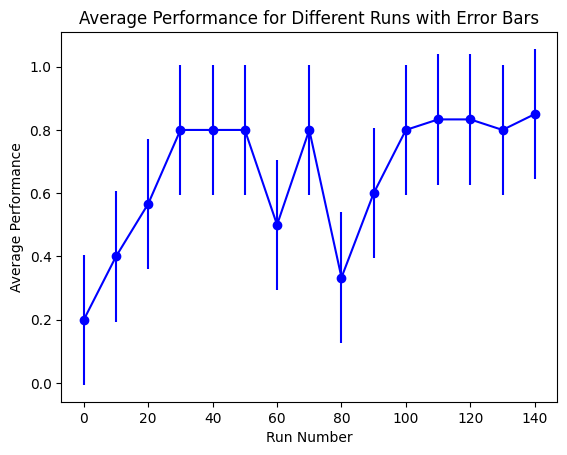

15
[0.8, 0.85, 0.9]


In [ ]:

#drawing the figure for average performance
std_deviation_list=[]
goh=[]
for performance_values in all_performance_values:
    c=sum(performance_values) / len(performance_values)
    goh.append(c)
    std_deviation = [np.std(goh)]
    std_deviation_list.append(std_deviation)
    import numpy as np
datapoints=range(0,10*len(goh),10 )
plt.errorbar(datapoints, goh, yerr=std_deviation, fmt='-o', color='blue')
plt.xlabel('Run Number')
plt.ylabel('Average Performance')
plt.title('Average Performance for Different Runs with Error Bars')
plt.show()
#plt.plot(goh)
print(len(goh))
print(performance_values)
import numpy as np
import matplotlib.pyplot as plt

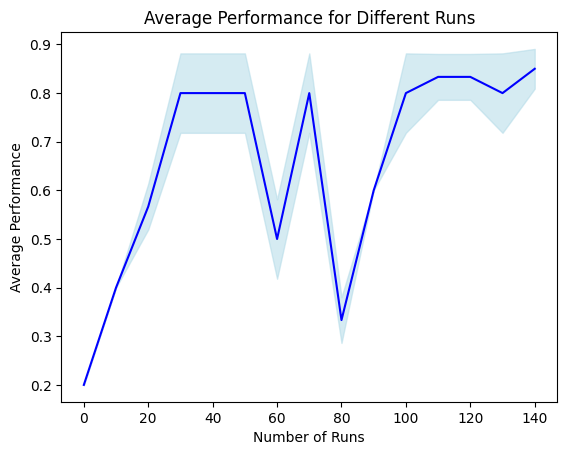

15
[0.8, 0.85, 0.9]


In [ ]:

# This code calculates the mean and standard deviation of performance values for different runs,
# then visualizes the results using a line plot with a shaded error margin.

# Initialize lists to store standard deviations and mean values
std_deviation_list = []
goh = []

# Iterate through performance values for different runs
for performance_values in all_performance_values:
    c = sum(performance_values) / len(performance_values)  # Calculate the mean
    goh.append(c)  # Store the mean value
    std_deviation = np.std(performance_values[-5:])  # Compute the standard deviation of the last two values
    std_deviation_list.append(std_deviation)  # Store the standard deviation

# Create data points for plotting
datapoints = np.arange(0, 10 * len(goh), 10)

# Plot the mean performance with an error margin
plt.fill_between(datapoints, np.subtract(goh, std_deviation_list),
                 np.add(goh, std_deviation_list), color='lightblue', alpha=0.5)  # Shaded error margin
plt.plot(datapoints, goh, color='blue')  # Line plot of mean values
plt.xlabel('Number of Runs')  # X-axis label
plt.ylabel('Average Performance')  # Y-axis label
plt.title('Average Performance for Different Runs')  # Title of the plot
plt.show()  # Display the plot

# Additional plot of mean values over iterations
#plt.plot(goh)
print(len(goh))  # Print the number of mean values calculated
print(performance_values)  # Print the last set of performance values processed

In [ ]:

#Jadide 2
import numpy as np

# Initialize variables
performancep = 0
consecutive_correct = 0
suclist = []
ll = [[], []]
ids = []
response_threshold = 9
trial_duration = 200
dopamine_input_duration = 300
deactivate_input_duration = 30
calcium_trace_decline_duration = 100
nr_fish_presentations = 100
nr_saccades = 4  # Number of saccades to simulate
chunk_data = []
weight_monitor=[]
# Main loop for presentations
for _ in range(nr_fish_presentations):
    if performancep >= 70:  # Stop if performance reaches the threshold
        break

    simulate(100)
    mon.reset()
    chunk_data=[]
    # Fetch fish and associated features
    fish = get_fish(fish_list, feature_name_list)
    category_true = get_true_category(fish)

    # Initialize feature selection for saccades
    remaining_features = ["DF", "TF", "VF", "MA"]  # Features to be selected
    selected_features = []
    saccade_count = 0  # Track saccades

    # Saccade loop
    while saccade_count < nr_saccades and remaining_features:
        mon.start()

        # Read SC.r and find the index of the maximum response
        SC_values = [SC.r[feature_name_list.index(f)] for f in remaining_features]
        max_index = np.argmax(SC_values)

        # Select the feature corresponding to the maximum SC.r value
        feature_name = remaining_features[max_index]
        selected_features.append(feature_name)
        remaining_features.pop(max_index)

        # Activate the feature and simulate its effect
        select_input(feature_name, fish, IT, feature_name_list, baseline_it)
        simulate(trial_duration)

        # Read PM.r to check if a decision can be made
        response_value = np.max(PM.r)
        response_idx = np.argmax(PM.r)
       # print(response_value)
        if response_value > response_threshold:
            # Decision-making process
            IT.baseline = baseline_it
            simulate(deactivate_input_duration)

            category_selected = ["A", "B"][response_idx]
            print(f"{_} category_true: {category_true}; category_selected: {category_selected}; after {saccade_count + 1} saccades")

            chunk_data.append({
                'category_true': category_true,
                'category_selected': category_selected,
                'fish_features': fish,
                'saccade_count': saccade_count + 1,
                'correctness': category_selected == category_true
            })

            # Update reward and correctness
            if category_selected == category_true:
                ids.append(_)  # Store the index of the correct decisions
                if category_selected == "A":
                    ll[0].append(fish)
                elif category_selected == "B":
                    ll[1].append(fish)

                Reward_Layer.baseline = 1
                consecutive_correct += 1
                suclist.append(1)
            else:
                Reward_Layer.baseline = 0
                consecutive_correct = 0
                suclist.append(0)
            print(chunk_data)
            # Reward feedback
            SNc.firing = 1
            simulate(dopamine_input_duration)
            Reward_Layer.baseline = 0
            SNc.firing = 0
            simulate(calcium_trace_decline_duration)
            mon.pause()
            break
        else:
            # No decision, continue to the next feature
            saccade_count += 1
    weight_monitor.append(np.mean(ITMTL.w))  # recording the average of the weight changes
    # Update performance based on recent trials
    if len(suclist) > 50:
        performancep = sum(suclist[-50:])

    mon.reset()

# Final output
print(f"Total consecutive correct decisions: {consecutive_correct}")

0 category_true: A; category_selected: B; after 2 saccades
[{'category_true': 'A', 'category_selected': 'B', 'fish_features': {'DF': -1.0, 'TF': 0.0, 'VF': -1.0, 'MA': 0.0}, 'saccade_count': 2, 'correctness': False}]
1 category_true: B; category_selected: A; after 2 saccades
[{'category_true': 'B', 'category_selected': 'A', 'fish_features': {'DF': 0.0, 'TF': 0.0, 'VF': 0.0, 'MA': 0.0}, 'saccade_count': 2, 'correctness': False}]
2 category_true: B; category_selected: B; after 2 saccades
[{'category_true': 'B', 'category_selected': 'B', 'fish_features': {'DF': 0.0, 'TF': 0.0, 'VF': 0.0, 'MA': 0.0}, 'saccade_count': 2, 'correctness': True}]
3 category_true: B; category_selected: A; after 2 saccades
[{'category_true': 'B', 'category_selected': 'A', 'fish_features': {'DF': 1.0, 'TF': -1.0, 'VF': 1.0, 'MA': 0.5}, 'saccade_count': 2, 'correctness': False}]
4 category_true: A; category_selected: B; after 2 saccades
[{'category_true': 'A', 'category_selected': 'B', 'fish_features': {'DF': -1.0,

In [ ]:
import numpy as np

# Initial settings
performancep = 0  # Performance percentage
consecutive_correct = 0  # Count of consecutive correct classifications
suclist = []  # List storing success/failure (1 for correct, 0 for incorrect)
ll = [[], []]  # Lists to store categorized fish
ids = []  # List of trial IDs where classification was correct
response_threshold = 9.05  # Threshold for decision-making
trial_duration = 200  # Duration of each trial (ms)
dopamine_input_duration = 300  # Duration of dopamine reward simulation (ms)
deactivate_input_duration = 30  # Time to deactivate input after response (ms)
calcium_trace_decline_duration = 100  # Time for calcium trace decline simulation (ms)
nr_fish_presentations = 100  # Total number of fish presentations (trials)
nr_saccades = 4  # Maximum number of allowed saccades per trial
chunk_data = []  # List for storing trial data
weight_monitor = []  # List for tracking weight changes

# Fish presentation loop
for _ in range(nr_fish_presentations):
    if performancep >= 70:  # Stop if performance threshold is reached
        break

    simulate(100)  # Pre-trial simulation for stabilization
    mon.reset()  # Reset monitoring system

    # Retrieve fish information
    fish = get_fish(fish_list, feature_name_list)
    category_true = get_true_category(fish)  # Get the correct category for the fish

    # Sort features based on SC.r values (before starting saccades)
    SC_values = [SC.r[feature_name_list.index(f)] for f in ["DF", "TF", "VF", "MA"]]
    sorted_features = [x for _, x in sorted(zip(SC_values, ["DF", "TF", "VF", "MA"]), reverse=True)]

    # Feature selection for saccades
    selected_features = []
    saccade_count = 0

    # Iterate through sorted features, limiting to nr_saccades
    for feature_name in sorted_features[:nr_saccades]:
        mon.start()  # Start monitoring

        selected_features.append(feature_name)

        # Activate the selected feature and simulate its effect
        select_input(feature_name, fish, IT, feature_name_list, baseline_it)
        simulate(trial_duration)

        # Check response value in PM.r
        response_value = np.max(PM.r)
        response_idx = np.argmax(PM.r)

        if response_value > response_threshold:
            # Final decision-making
            IT.baseline = baseline_it
            simulate(deactivate_input_duration)

            category_selected = ["A", "B"][response_idx]  # Determine selected category
            print(f"{_} category_true: {category_true}; category_selected: {category_selected}; after {saccade_count + 1} saccades")

            # Store trial data
            chunk_data.append({
                'category_true': category_true,
                'category_selected': category_selected,
                'fish_features': fish,
                'saccade_count': saccade_count + 1,
                'correctness': category_selected == category_true
            })

            # Reward mechanism based on correct classification
            if category_selected == category_true:
                ids.append(_)  # Store trial ID
                ll[0 if category_selected == "A" else 1].append(fish)  # Categorize the fish
                Reward_Layer.baseline = 1  # Activate reward system
                consecutive_correct += 1  # Increase correct streak count
                suclist.append(1)  # Mark trial as successful
            else:
                Reward_Layer.baseline = 0  # No reward for incorrect classification
                consecutive_correct = 0  # Reset correct streak count
                suclist.append(0)  # Mark trial as incorrect

            # Apply dopamine reward
            SNc.firing = 1  # Trigger dopamine response
            simulate(dopamine_input_duration)
            Reward_Layer.baseline = 0  # Reset reward system
            SNc.firing = 0
            simulate(calcium_trace_decline_duration)  # Simulate calcium trace decline

            mon.pause()
            break  # Exit saccade loop after decision-making

        saccade_count += 1  # Increment saccade count

    # Store average synaptic weight changes
    weight_monitor.append(np.mean(ITMTL.w))

    # Update performance based on the last 50 trials
    if len(suclist) > 50:
        performancep = sum(suclist[-50:])

    mon.reset()  # Reset monitoring system after each trial

# Display final results
print(f"Total consecutive correct decisions: {consecutive_correct}")

1 category_true: B; category_selected: A; after 2 saccades
2 category_true: B; category_selected: A; after 2 saccades
3 category_true: B; category_selected: A; after 2 saccades
4 category_true: B; category_selected: A; after 3 saccades
5 category_true: A; category_selected: A; after 3 saccades
6 category_true: B; category_selected: A; after 3 saccades
7 category_true: A; category_selected: A; after 4 saccades
9 category_true: B; category_selected: A; after 2 saccades
10 category_true: B; category_selected: A; after 3 saccades
11 category_true: A; category_selected: A; after 2 saccades
12 category_true: B; category_selected: A; after 3 saccades
13 category_true: B; category_selected: A; after 3 saccades
14 category_true: A; category_selected: A; after 3 saccades
15 category_true: A; category_selected: B; after 4 saccades
16 category_true: B; category_selected: B; after 2 saccades
17 category_true: A; category_selected: A; after 1 saccades
18 category_true: B; category_selected: B; after

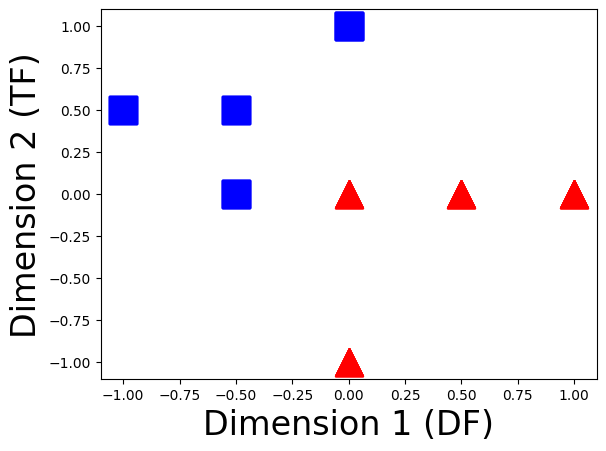

In [ ]:
ol=[]
al=[]
for k in range(min(len(ll[0]),len(ll[1]))):
   al.append([ll[0][k]['DF'],ll[0][k]['TF']])

   ol.append([ll[1][k]['DF'],ll[1][k]['TF']])
for j in range(min(len(ll[0]),len(ll[1]))):
   plt.plot(al[j][0], al[j][1], 's', markeredgecolor='b', markerfacecolor='b', markersize=20)
   plt.plot(ol[j][0], ol[j][1], '^', markeredgecolor='r', markerfacecolor='r', markersize=20)
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.ylabel('Dimension 2 (TF)', fontsize=24)
plt.xlabel('Dimension 1 (DF)', fontsize=24)
plt.show()

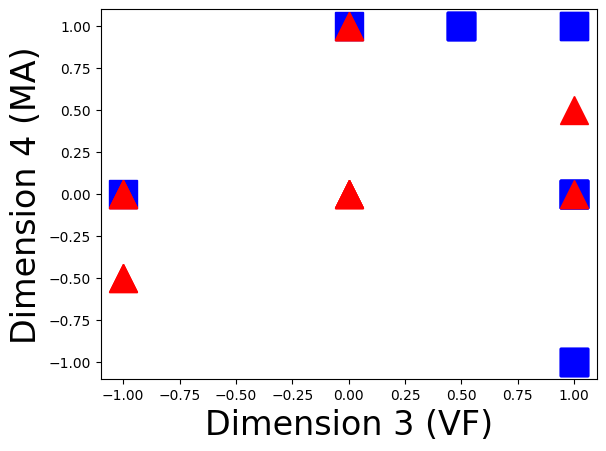

In [ ]:

ol=[]
al=[]
for k in range(min(len(ll[0]),len(ll[1]))):
   al.append([ll[0][k]['VF'],ll[0][k]['MA']])

   ol.append([ll[1][k]['VF'],ll[1][k]['MA']])
for j in range(min(len(ll[0]),len(ll[1]))):
   plt.plot(al[j][0], al[j][1], 's', markeredgecolor='b', markerfacecolor='b', markersize=20)
   plt.plot(ol[j][0], ol[j][1], '^', markeredgecolor='r', markerfacecolor='r', markersize=20)
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.ylabel('Dimension 4 (MA)', fontsize=24)

plt.xlabel('Dimension 3 (VF)', fontsize=24)
plt.show()

In [ ]:
print(SC.r)
print(consecutive_correct)
print(ids)

[0. 0. 0. 0.]
0
[3, 4, 9, 12, 13, 18, 21, 22, 23, 24, 25, 26, 30, 31, 32, 33, 35, 37, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 53, 54, 55, 58, 59, 67, 69, 73, 74, 75, 78, 84, 85, 87, 90]


In [ ]:
recordings = mon.get_recordings()

recording_times = mon.get_recording_times()
print(recording_times)
my = ['IT;r', 'Reward_Layer;r', 'PFC_MTL;r', 'SNc;r', 'StrD1;r', 'StrD2;r',
      'StrThal-PFC;r', 'GPi-PFC;r', 'STN;r', 'GPe;r', 'VA-PFC;r', 'PM;r']
#for m in my:
   # v=[x[m] for x in recordings]
#np.savetxt('recordings.csv',v,delimiter=",")
# np.savetxt('recording_times.csv',recording_times,delimiter=",")
myx=[x['IT;r'] for x in recordings]

In [ ]:
np.shape(weight_monitor)

(100,)

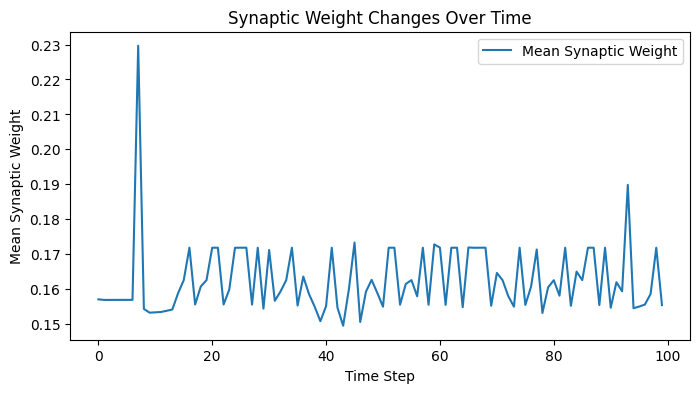

In [ ]:
for i in range(1):
 time_steps=100
 plt.figure(figsize=(8, 4))
 plt.plot( range(100),weight_monitor, label='Mean Synaptic Weight')
 plt.xlabel('Time Step')
 plt.ylabel('Mean Synaptic Weight')
 plt.title('Synaptic Weight Changes Over Time')
 plt.legend()
 plt.show()

In [ ]:
for chunk in range(7):
        ### using plot_recordings which plots the recordings of one chunk
        PlotRecordings(
            figname=f"monitor_recordings_1_chunk{chunk}.png",
            recordings=recordings,
            #recording_times=recording_times,
            recording_times=recording_times,
            shape=(2,2),
            plan={
                "position": [1,2,3,4],
                "compartment": ["IT", "StrD1","StrD2","STN"],
                "variable": ["r", "r", "r","r"],
                "format": ["matrix", "matrix", "matrix", "matrix"],
            },
            chunk=chunk,

        )
        plt.savefig(f"pw3{chunk}.png")
        print(chunk)

Generate fig monitor_recordings_1_chunk0.png... Done

0
Generate fig monitor_recordings_1_chunk1.png... Done

1
Generate fig monitor_recordings_1_chunk2.png... Done

2
Generate fig monitor_recordings_1_chunk3.png... Done

3
Generate fig monitor_recordings_1_chunk4.png... Done

4
Generate fig monitor_recordings_1_chunk5.png... Done

5
Generate fig monitor_recordings_1_chunk6.png... Done

6


<Figure size 640x480 with 0 Axes>

In [ ]:
for chunk in range(7):
        ### using plot_recordings which plots the recordings of one chunk
        PlotRecordings(
            figname=f"second-monitor_recordings_1_chunk{chunk}.png",
            recordings=recordings,
            #recording_times=recording_times,
            recording_times=recording_times,
            shape=(2,2),
            plan={
                "position": [1,2,3,4],
                "compartment": ["GPi", "VA-PFC","PM", "SC"],
                "variable": ["r", "r", "r","r"],
                "format": ["matrix", "matrix", "matrix", "matrix"],
            },
            chunk=chunk,

        )
        plt.savefig(f"pw3{chunk}.png")
        print(chunk)

Generate fig second-monitor_recordings_1_chunk0.png... Done

0
Generate fig second-monitor_recordings_1_chunk1.png... Done

1
Generate fig second-monitor_recordings_1_chunk2.png... Done

2
Generate fig second-monitor_recordings_1_chunk3.png... Done

3
Generate fig second-monitor_recordings_1_chunk4.png... Done

4
Generate fig second-monitor_recordings_1_chunk5.png... Done

5
Generate fig second-monitor_recordings_1_chunk6.png... Done

6


<Figure size 640x480 with 0 Axes>

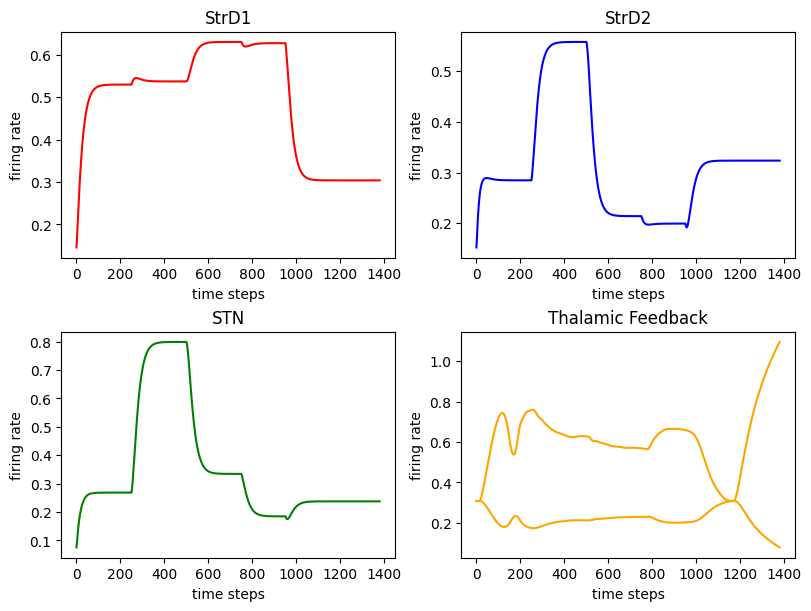

In [ ]:
x = recordings
fig, ax = plt.subplots(2, 2, figsize=(8, 6), constrained_layout=True)
ax = ax.flatten()

# Plot Curves:

ax[0].plot(x[5]['StrD1;r'][:,6], color='red')
ax[0].set_title('StrD1')
ax[0].set_xlabel('time steps')
ax[0].set_ylabel('firing rate')

ax[1].plot(x[5]['StrD2;r'][:,7], color='blue')
ax[1].set_title('StrD2')
ax[1].set_xlabel('time steps')
ax[1].set_ylabel('firing rate')

ax[2].plot(x[5]['STN;r'][:,7], color='green')
ax[2].set_title('STN')
ax[2].set_xlabel('time steps')
ax[2].set_ylabel('firing rate')

ax[3].plot(x[5]['StrThal-PFC;r'], color='orange')
ax[3].set_title('Thalamic Feedback')
ax[3].set_xlabel('time steps')
ax[3].set_ylabel('firing rate')


plt.show()

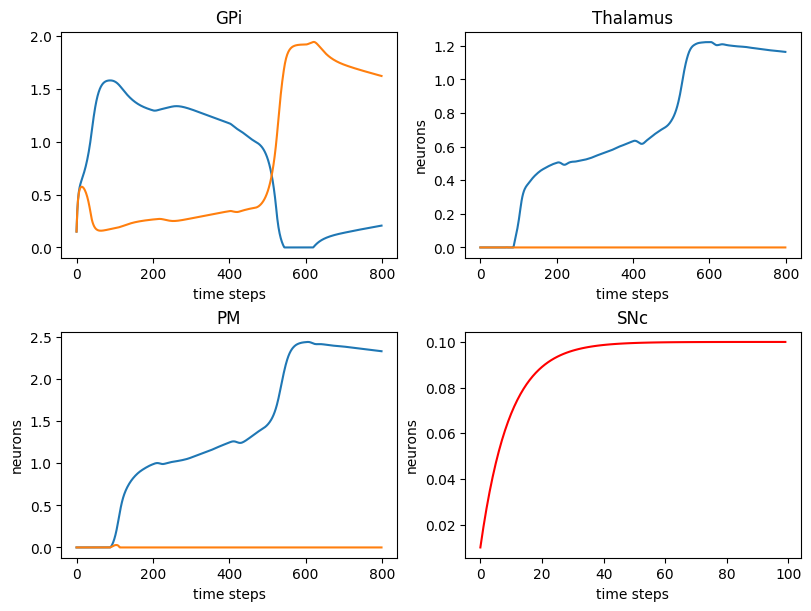

In [ ]:
x = recordings
fig, ax = plt.subplots(2, 2, figsize=(8, 6), constrained_layout=True)
ax = ax.flatten()

# Plot Curves:

ax[0].plot(x[5]['GPi;r'])
ax[0].set_title('GPi')
ax[0].set_xlabel('time steps')



ax[1].plot(x[5]['VA-PFC;r'])
ax[1].set_title('Thalamus')
ax[1].set_xlabel('time steps')
ax[1].set_ylabel('neurons')

ax[2].plot(x[5]['PM;r'])
ax[2].set_title('PM')
ax[2].set_xlabel('time steps')
ax[2].set_ylabel('neurons')

ax[3].plot(x[4]['SNc;r'], color='red')
ax[3].set_title('SNc')
ax[3].set_xlabel('time steps')
ax[3].set_ylabel('neurons')
plt.show()

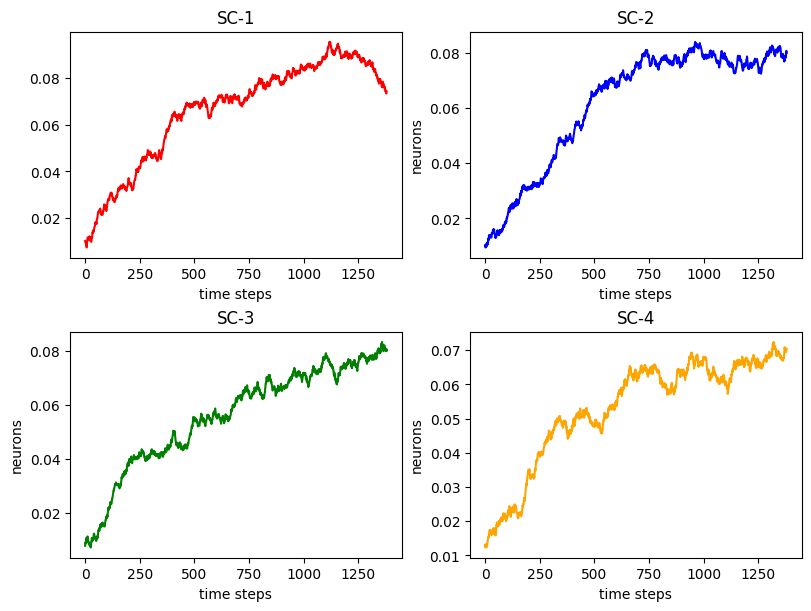

In [ ]:
x = recordings
fig, ax = plt.subplots(2, 2, figsize=(8, 6), constrained_layout=True)
ax = ax.flatten()

# Plot Curves:

ax[0].plot(x[3]['SC;r'][:,0],color='red')
ax[0].set_title('SC-1')
ax[0].set_xlabel('time steps')



ax[1].plot(x[3]['SC;r'][:,1],color='blue')
ax[1].set_title('SC-2')
ax[1].set_xlabel('time steps')
ax[1].set_ylabel('neurons')

ax[2].plot(x[3]['SC;r'][:,2],color='green')
ax[2].set_title('SC-3')
ax[2].set_xlabel('time steps')
ax[2].set_ylabel('neurons')

ax[3].plot(x[3]['SC;r'][:,3], color='orange')
ax[3].set_title('SC-4')
ax[3].set_xlabel('time steps')
ax[3].set_ylabel('neurons')
plt.show()

<Axes: >

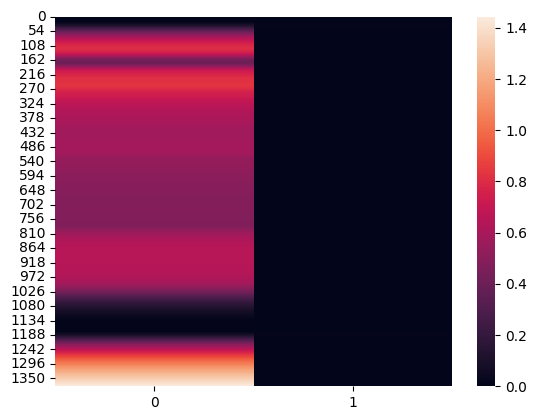

In [ ]:
import seaborn as sns
x=recordings
sns.heatmap(x[5]['PM;r'])

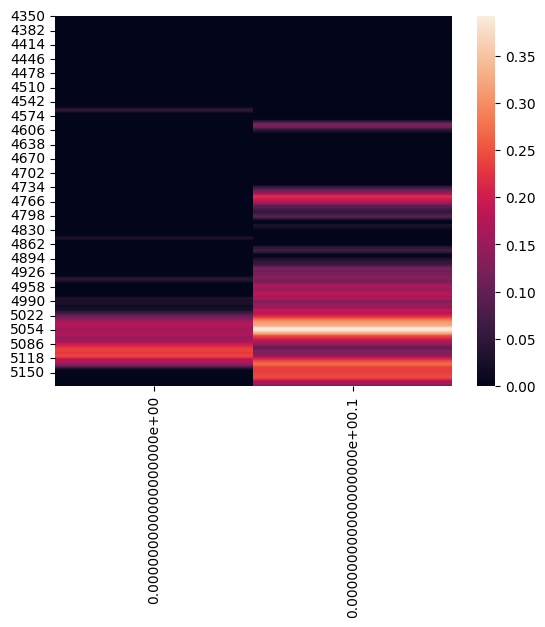

In [ ]:
1import os
os.getcwd( )
import pandas as pd
df=pd.read_csv('dataVA-PFC.csv')
df2=df[4350:5180]
fig, ax=plt.subplots()
import seaborn as sns
sns.heatmap(df2)
ax.xlabel='Primary Motor Cortex'